In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import plot_images_full, generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

#from models.vit import ViT, SimpleViT, SimpleViTI, SimpleViTFT
from models.diffusion import SimpleTransformer

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
batch_size = 32
device = 'cuda:0'
data_path = './data/'

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def eval_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = val_acc = 0.0
    for (img, labels) in val_loader:
        img, labels = img.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(img)
            loss = criterion(predictions, labels)
            correct = torch.argmax(predictions.data, 1) == labels
        val_loss += loss
        val_acc += correct.sum()
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
        
    print(f" Test acc {val_acc:.3f}, Test loss {val_loss:.6f}")

In [5]:
depth=64
def get_model(m,s,wn,t,ws,acc):
    model = SimpleTransformer((3,32,32), 2, depth, 
        dim=128, 
        heads=1,
        num_classes=10, 
        sign=s, 
        tau=t, 
        embed=True,
        softw=False,
        weight_sharing=ws, 
        method=m,
        norm=True,
        weight_norm=wn,
        attn_norm=False
    )
    model.load_state_dict(torch.load(f"model_method_{m}_sign_{s}_tau_{t}_wn_{wn}_ws_{ws}_acc_{acc}.pth"))
    return model

In [6]:
image = next(iter(val_loader))[0].to(device)

In [7]:
#plt.imshow(A0[0,:].reshape(32,32))

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [8]:
model = get_model(m='TV',s=0,wn=False,t=1,ws=False,acc=10).to(device)

In [146]:
#model.attn_norm = False
#model.weight_norm = True

In [147]:
outputs, attentions, Ws = model.diffuse(image)

In [148]:
torch.linalg.eig(Ws[0]).eigenvalues

tensor([-0.4957+1.4167j, -0.4957-1.4167j,  0.8068+1.1556j,  0.8068-1.1556j,
        -1.3105+0.6346j, -1.3105-0.6346j, -1.4025+0.0511j, -1.4025-0.0511j,
         0.4173+1.3122j,  0.4173-1.3122j,  1.0501+0.7900j,  1.0501-0.7900j,
        -0.2893+1.2552j, -0.2893-1.2552j,  1.2904+0.1706j,  1.2904-0.1706j,
         0.9257+0.8678j,  0.9257-0.8678j,  1.1301+0.5925j,  1.1301-0.5925j,
        -1.2772+0.0000j,  0.2631+1.2382j,  0.2631-1.2382j, -1.1031+0.5778j,
        -1.1031-0.5778j, -0.7055+1.0198j, -0.7055-1.0198j,  1.2408+0.0141j,
         1.2408-0.0141j, -1.1640+0.3718j, -1.1640-0.3718j,  0.0243+1.2408j,
         0.0243-1.2408j, -0.8909+0.8089j, -0.8909-0.8089j,  1.1229+0.3382j,
         1.1229-0.3382j, -1.1706+0.0000j,  0.3158+1.1530j,  0.3158-1.1530j,
         0.7638+0.8619j,  0.7638-0.8619j, -0.9047+0.7562j, -0.9047-0.7562j,
         1.0133+0.5310j,  1.0133-0.5310j, -1.1336+0.0000j,  0.0314+1.1451j,
         0.0314-1.1451j, -0.5183+1.0017j, -0.5183-1.0017j, -0.2311+1.0938j,
        -0.2

In [149]:
torch.linalg.eig(torch.from_numpy(attentions[0])).eigenvalues

tensor([[ 1.0000e+00+0.0000e+00j, -5.7756e-01+0.0000e+00j,
          4.7158e-02+4.5760e-01j,  ...,
         -3.2184e-06+1.0348e-05j, -3.2184e-06-1.0348e-05j,
          3.1269e-05+0.0000e+00j],
        [ 1.0000e+00+0.0000e+00j,  1.4811e-01+6.8650e-01j,
          1.4811e-01-6.8650e-01j,  ...,
          2.4978e-05+4.7611e-05j,  2.4978e-05-4.7611e-05j,
          6.9085e-05+0.0000e+00j],
        [ 1.0000e+00+0.0000e+00j, -7.6626e-01+0.0000e+00j,
          5.0157e-01+0.0000e+00j,  ...,
         -2.1816e-07-3.9629e-07j,  1.8458e-07+0.0000e+00j,
         -6.0833e-07+0.0000e+00j],
        ...,
        [ 1.0000e+00+0.0000e+00j,  6.7129e-01+0.0000e+00j,
          3.6158e-01+3.3251e-01j,  ...,
          2.2779e-06-1.3251e-05j,  1.7294e-07+0.0000e+00j,
          7.7067e-07+0.0000e+00j],
        [ 1.0000e+00+0.0000e+00j,  1.2052e-01+4.9950e-01j,
          1.2052e-01-4.9950e-01j,  ...,
          1.0302e-06+0.0000e+00j, -2.0641e-05+0.0000e+00j,
          1.4465e-05+0.0000e+00j],
        [ 1.0000e+00+0

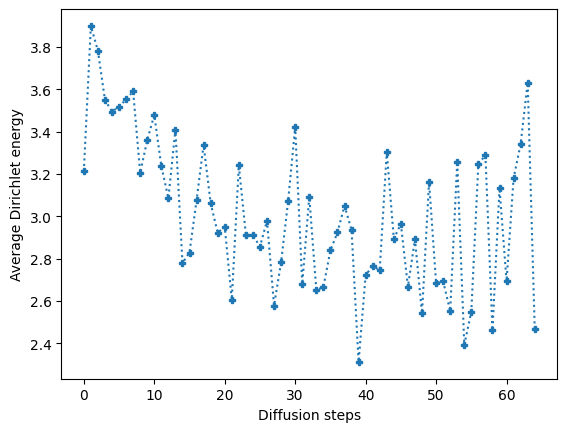

In [150]:
dirichlet_input = [x/(np.linalg.norm(x)+1e-9) for x in outputs]
similarities = get_similarities(dirichlet_input)
plot_similarities(similarities)

In [151]:
similarities[-1]

2.466191976605305

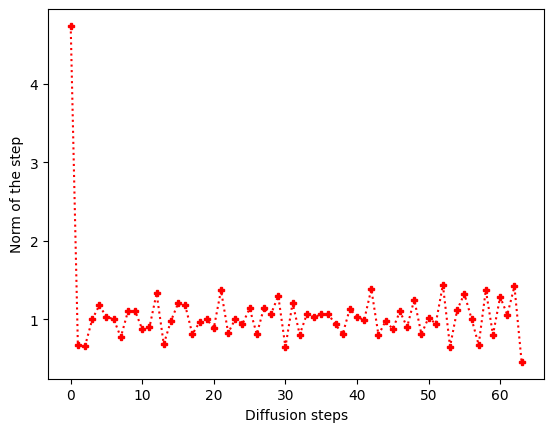

In [152]:
differences = get_differences(outputs)
plot_differences(differences)

In [153]:
differences[-1]

0.45641023781670975

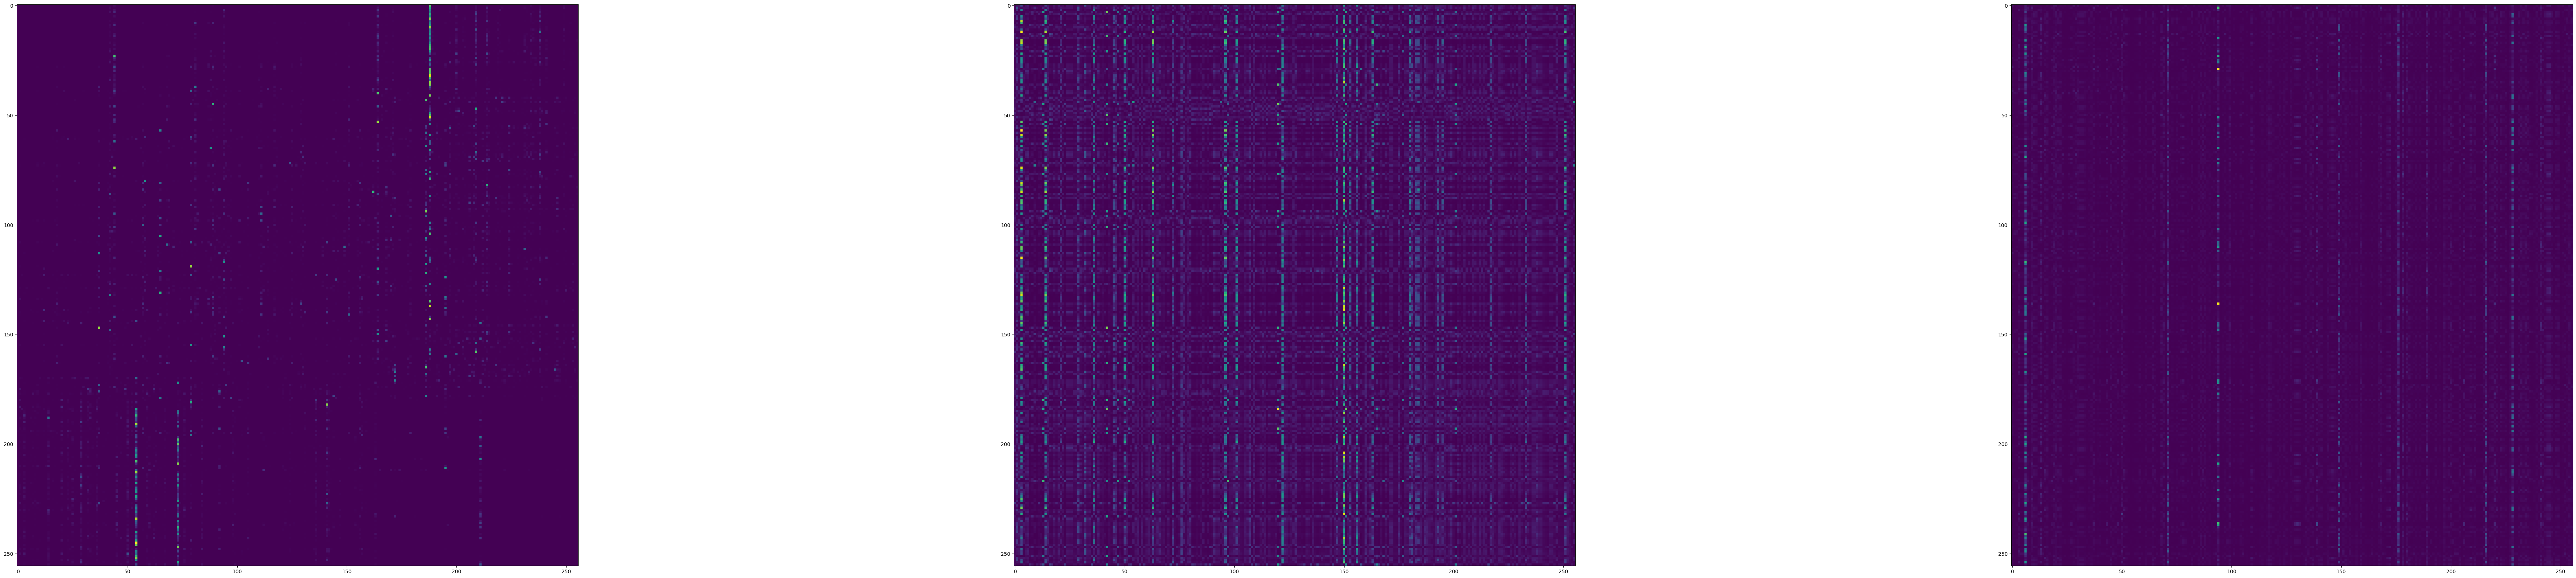

In [154]:
plot_images_full([attentions[0],attentions[30],attentions[-1]])

In [155]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.100, Test loss 0.072262


In [106]:
model.depth = 32
model.tau = 0.5

In [104]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.337, Test loss 0.054637


In [107]:
model.depth = 32
model.tau = (depth*model.tau)/model.depth
model.tau

1.0

In [98]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.115, Test loss 0.138448
